In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import animation
from IPython.display import HTML


In [ ]:
seed = 7
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
def make_data(fn, n=256, x_min=-2.0, x_max=2.0, noise_std=0.0):
    x = np.linspace(x_min, x_max, n).reshape(-1, 1).astype(np.float32)
    y = fn(x).astype(np.float32)
    if noise_std > 0:
        y = y + np.random.normal(0, noise_std, size=y.shape).astype(np.float32)

    x_t = torch.tensor(x, device=device)
    y_t = torch.tensor(y, device=device)
    return x, y, x_t, y_t

# Your target functions
f_lin  = lambda x: x
f_sq   = lambda x: x**2
f_cube = lambda x: x**3
f_mix  = lambda x: x**2 + x**3


In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )
    def forward(self, x):
        return self.net(x)

def train(model, x_t, y_t, steps=2000, lr=1e-3, record_every=25):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    history = {
        "step": [],
        "loss": [],
        "preds": []  # snapshots (for GIF)
    }

    for step in range(steps + 1):
        model.train()
        pred = model(x_t)
        loss = loss_fn(pred, y_t)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if step % record_every == 0:
            model.eval()
            with torch.no_grad():
                pred_eval = model(x_t).detach().cpu().numpy()
            history["step"].append(step)
            history["loss"].append(float(loss.detach().cpu().item()))
            history["preds"].append(pred_eval)

    return model, history


In [ ]:
x, y, x_t, y_t = make_data(f_sq, n=300, x_min=-2, x_max=2)

model_sq = MLP(hidden=32)
model_sq, hist_sq = train(model_sq, x_t, y_t, steps=2500, lr=1e-3, record_every=25)

min(hist_sq["loss"]), hist_sq["loss"][-1]


(0.0001006921156658791, 0.0001006921156658791)

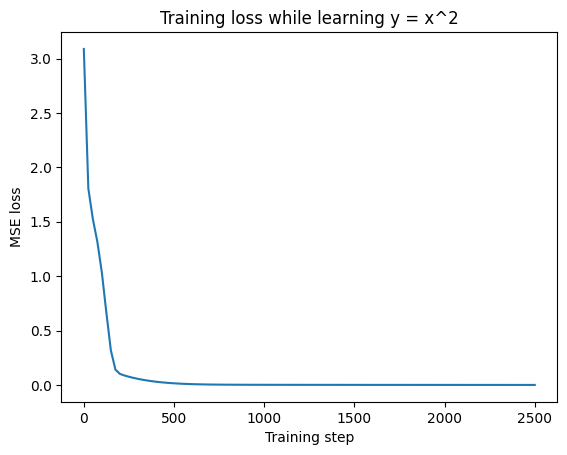

In [ ]:
plt.figure()
plt.plot(hist_sq["step"], hist_sq["loss"])
plt.xlabel("Training step")
plt.ylabel("MSE loss")
plt.title("Training loss while learning y = x^2")
plt.show()


In [ ]:
# Prepare for animation
fig, ax = plt.subplots()
ax.set_title("MLP learning y = x^2 (convergence)")
ax.set_xlabel("x")
ax.set_ylabel("y")

# True curve
ax.plot(x.flatten(), y.flatten(), linewidth=2, label="True: x^2")

# Pred curve (animated)
pred_line, = ax.plot(x.flatten(), hist_sq["preds"][0].flatten(), linewidth=2, label="MLP prediction")

ax.legend()

def update(frame_idx):
    pred = hist_sq["preds"][frame_idx]
    pred_line.set_ydata(pred.flatten())
    ax.set_title(f"MLP learning y = x^2 — step {hist_sq['step'][frame_idx]} | loss {hist_sq['loss'][frame_idx]:.4e}")
    return (pred_line,)

anim = animation.FuncAnimation(
    fig, update, frames=len(hist_sq["preds"]), interval=80, blit=True
)

# Save GIF
gif_path = "mlp_convergence_x2.gif"
anim.save(gif_path, writer="pillow")
plt.close(fig)

gif_path


'mlp_convergence_x2.gif'


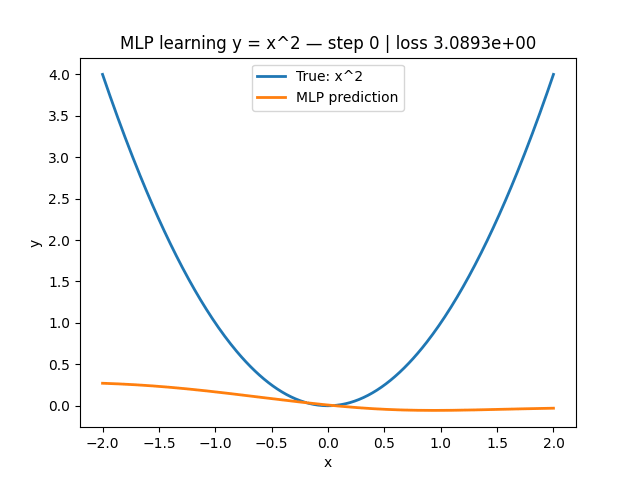

In [ ]:
import base64
from pathlib import Path

data = Path("mlp_convergence_x2.gif").read_bytes()
b64 = base64.b64encode(data).decode("utf-8")
HTML(f'<img src="data:image/gif;base64,{b64}" />')


In [ ]:
targets = [
    ("y = x", f_lin),
    ("y = x^2", f_sq),
    ("y = x^3", f_cube),
    ("y = x^2 + x^3", f_mix),
]

trained = []

for name, fn in targets:
    x, y, x_t, y_t = make_data(fn, n=300, x_min=-2, x_max=2)
    m = MLP(hidden=32)
    m, h = train(m, x_t, y_t, steps=2500, lr=1e-3, record_every=100)  # no need dense snapshots here
    with torch.no_grad():
        pred = m(x_t).detach().cpu().numpy()
    trained.append((name, x, y, pred))


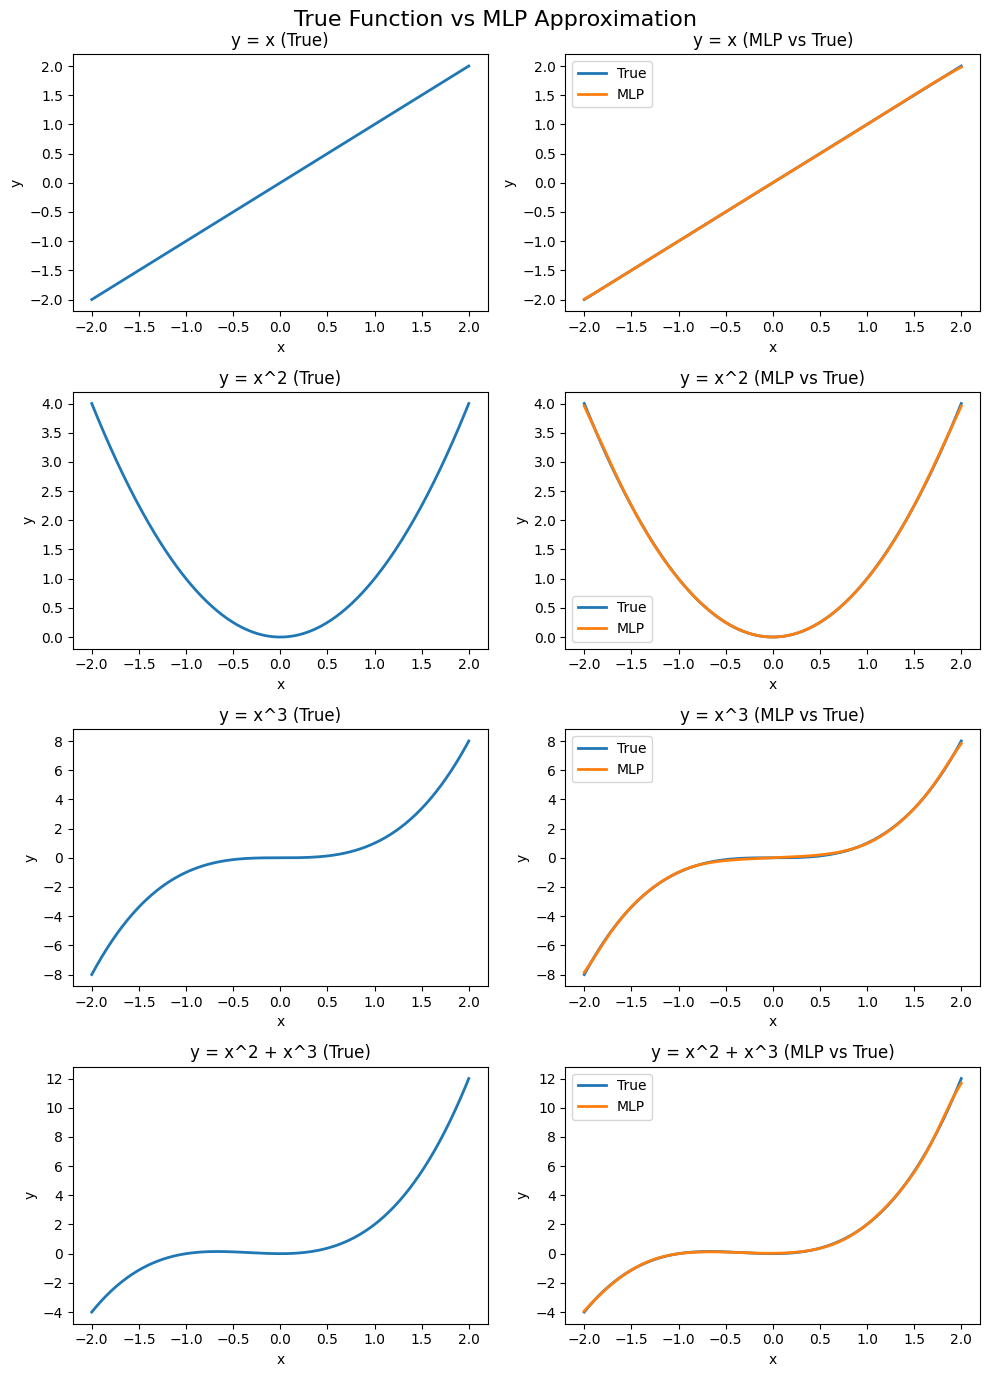

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 14))
fig.suptitle("True Function vs MLP Approximation", fontsize=16)

for i, (name, x, y, pred) in enumerate(trained):
    ax_true = axes[i, 0]
    ax_nn   = axes[i, 1]

    ax_true.plot(x.flatten(), y.flatten(), linewidth=2)
    ax_true.set_title(f"{name} (True)")
    ax_true.set_xlabel("x")
    ax_true.set_ylabel("y")

    ax_nn.plot(x.flatten(), y.flatten(), linewidth=2, label="True")
    ax_nn.plot(x.flatten(), pred.flatten(), linewidth=2, label="MLP")
    ax_nn.set_title(f"{name} (MLP vs True)")
    ax_nn.set_xlabel("x")
    ax_nn.set_ylabel("y")
    ax_nn.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import animation

np.random.seed(0)
torch.manual_seed(0)

# Generate linearly separable data
n = 200
X = np.random.randn(n, 2)
y = (X[:, 0] + X[:, 1] > 0).astype(np.float32)

X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y).view(-1, 1)


In [ ]:
class Perceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        return self.linear(x)

model = Perceptron()
opt = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.BCEWithLogitsLoss()

weights = []

for step in range(80):
    logits = model(X_t)
    loss = loss_fn(logits, y_t)

    opt.zero_grad()
    loss.backward()
    opt.step()

    w = model.linear.weight.detach().numpy().copy()
    b = model.linear.bias.detach().numpy().copy()
    weights.append((w, b))


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.7)
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.7)

x_vals = np.linspace(-3, 3, 100)
line, = ax.plot([], [], 'k', linewidth=2)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_title("Single Perceptron Learning a Linear Boundary")

def update(frame):
    w, b = weights[frame]
    y_vals = -(w[0][0] * x_vals + b[0]) / w[0][1]
    line.set_data(x_vals, y_vals)
    return line,

anim = animation.FuncAnimation(fig, update, frames=len(weights), interval=100)
anim.save("perceptron_linear_convergence.gif", writer="pillow")
plt.close()

"perceptron_linear_convergence.gif"


'perceptron_linear_convergence.gif'

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.15, random_state=0)
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y).view(-1, 1).float()

model = Perceptron()
opt = optim.SGD(model.parameters(), lr=0.1)

for _ in range(300):
    logits = model(X_t)
    loss = loss_fn(logits, y_t)

    opt.zero_grad()
    loss.backward()
    opt.step()

w = model.linear.weight.detach().numpy()
b = model.linear.bias.detach().numpy()


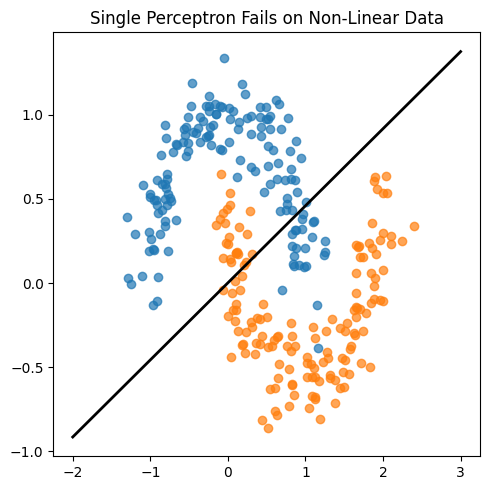

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.7)
plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.7)

x_vals = np.linspace(-2, 3, 200)
y_vals = -(w[0][0] * x_vals + b[0]) / w[0][1]

plt.plot(x_vals, y_vals, 'k', linewidth=2)
plt.title("Single Perceptron Fails on Non-Linear Data")
plt.tight_layout()
plt.savefig("perceptron_failure.png", dpi=200)
plt.show()


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

mlp = MLP()
opt = optim.Adam(mlp.parameters(), lr=0.01)

for _ in range(2000):
    logits = mlp(X_t)
    loss = loss_fn(logits, y_t)

    opt.zero_grad()
    loss.backward()
    opt.step()


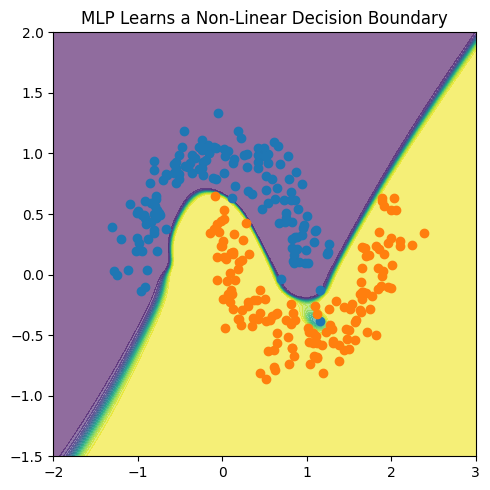

In [ ]:
xx, yy = np.meshgrid(
    np.linspace(-2, 3, 300),
    np.linspace(-1.5, 2, 300)
)

grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    preds = torch.sigmoid(mlp(grid)).numpy().reshape(xx.shape)

plt.figure(figsize=(5, 5))
plt.contourf(xx, yy, preds, levels=20, alpha=0.6)
plt.scatter(X[y == 0, 0], X[y == 0, 1])
plt.scatter(X[y == 1, 0], X[y == 1, 1])

plt.title("MLP Learns a Non-Linear Decision Boundary")
plt.tight_layout()
plt.savefig("mlp_success.png", dpi=200)
plt.show()
